# CarRacing with VAEGAN

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/Artificial Intelligence/World Models/WorldModels")

Mounted at /content/gdrive


In [2]:
!pip install Box2D
!pip install ConfigArgParse
import os
import numpy as np
import json
import tensorflow as tf
import random
from vaegan import enc, dec
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/carracing.config'])

     |████████████████████████████████| 1.3MB 5.6MB/s 
     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for ConfigArgParse: filename=ConfigArgParse-1.4-cp37-none-any.whl size=19638 sha256=b5697990f9366abb3c2332842435c73a5c858360174cfb09e4f9aafbbbbd8ec1
  Stored in directory: /root/.cache/pip/wheels/d6/61/f7/626bbd080a9f2f70015f92025e0af663c595146083f3d9aa05
Successfully built ConfigArgParse


In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vaegan".format(args.exp_name, args.env_name)

In [5]:
filelist = os.listdir(DATA_DIR)

In [6]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [7]:
obs.shape

(1000, 64, 64, 3)

In [8]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

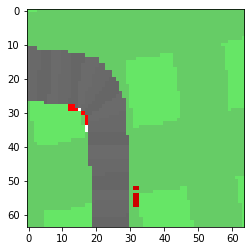

In [9]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [10]:
vaegan_enc, vaegan_dec = enc(), dec()
vaegan_enc.load_weights("results/WorldModels/CarRacing-v0/tf_vaegan/enc.h5")
vaegan_dec.load_weights("results/WorldModels/CarRacing-v0/tf_vaegan/dec.h5")

In [11]:
batch_z = vaegan_enc(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vaegan_dec(batch_z[0])

tf.Tensor(
[[ 1.169   0.7111  1.2723 -0.0174 -1.4644 -1.8307 -2.119  -0.9128  1.1239  0.6862  0.0483 -0.2151
  -0.8973 -0.1503 -1.3984 -0.7266 -1.6475  1.6355 -0.0614  0.0954 -0.1412  0.6116 -2.2242 -0.1539
  -0.5191 -0.2446  0.0983 -1.1913  1.1868  0.1586 -0.7014 -0.6398]], shape=(1, 32), dtype=float32)


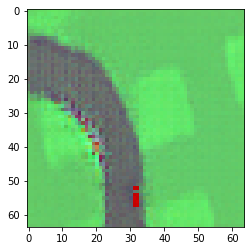

In [12]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

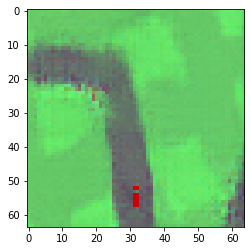

In [13]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vaegan_dec(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Return Plot for Controller

In [14]:
eager_filepath = os.path.join('results/{}/{}/log_vaegan/{}.cma.16.4.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))
og_filepath = os.path.join('results/og/log', 'carracing.cma.16.64.hist_best.json')
with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
with open(og_filepath, 'r') as f:
  og_data = json.load(f)

eager_data = np.array(eager_data)
og_data = np.array(og_data)

eager_comparison_max = eager_data[-1, 0] # b/c we didnt run for 2k
og_max_idx = np.sum(np.array(og_data[: ,0],dtype=np.float) <= eager_comparison_max)
print(og_max_idx)

og_data = np.array(og_data)[:og_max_idx]

2


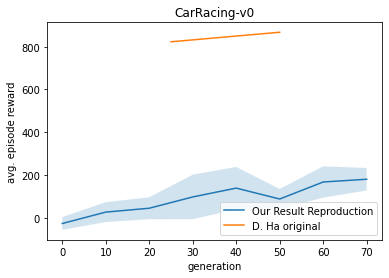

In [15]:
%matplotlib inline

eager_x = eager_data[:, 0]
eager_ret = eager_data[:, 1]
eager_std = eager_data[:, 2]

og_x = np.array(og_data[:, 0], dtype=np.float)
og_ret = np.array(og_data[:, 5], dtype=np.float)
# don't have access to standard deviation of the og evaluation

plt.figure()
plt.plot(eager_x, eager_ret)
plt.fill_between(eager_x, eager_ret-eager_std, eager_ret+eager_std, alpha=0.2)
plt.plot(og_x, og_ret)

plt.title('CarRacing-v0')
plt.ylabel('avg. episode reward')
plt.xlabel('generation')
plt.legend(['Our Result Reproduction', 'D. Ha original'])